In [1]:
%run ../initialize.ipynb

In [2]:
from pyspark.sql.window import Window

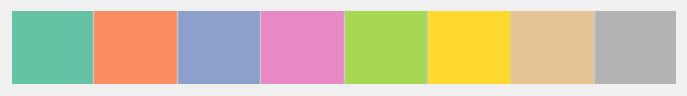

In [3]:
import sys
sys.path.append('../modeling-football-outcomes/config')
import mpl_style
colors = rcParams['axes.prop_cycle'].by_key()['color']

## Global Functions

In [4]:
def get_window(window_type, n, partition_cols, date_orderby_col):
    '''accepts window type (days, games, seasons),
     size of window n,
     and window fields (partition and sort), 
     and returns a spark Window'''
    assert type(partition_cols) is list
    assert type(date_orderby_col) is str
    assert type(n) is int
    assert window_type in ['games','days','seasons']
    
    from pyspark.sql.window import Window
    if window_type == 'games':
        ## fixed number of games
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).desc())\
                  .rowsBetween(1, n)

    elif window_type == 'days':
        ## fixed number of days
        seconds = 24*60*60*n
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

    elif window_type == 'seasons':
        ## fixed number of seasons, including current
        ## n = 1 is YTD
        seconds = 24*60*60*(180 + 365*(n-1))
        return Window.partitionBy(*partition_cols)\
                  .orderBy(col(date_orderby_col).cast('timestamp').cast('long'))\
                  .rangeBetween(-seconds, -1)

In [5]:
def get_wr_over_window(df, w, feat_name, success):
    '''Takes Spark DF, Spark Window obj,
    new column name, and success column,
    and computes the home team winrate
    over the window'''    
    return df.withColumn(
        feat_name, 
        ## sum of wins
        F.sum(success).over(w) 
        ## divided by count of games
        / F.count(F.lit(1)).over(w)
    )

## Setting up window functions
* fixed number of games, days, or seasons (including current)
* developed function to get the appropriate WindowSpec

#### getting the past N seasons, including the current one
* can't use a window of # of seasons, because it'll include future games in the current season
* can add an offset that always captures the current season, then add 365 days for each full season
* anything in range [157, 209] works as an offset for 2007-2017.
* choosing 180
* assertion of this, for all game dates 2007-2017, is below

In [6]:
games = spark.table('game').select('game_id','season',col('date').cast(TimestampType()),
                                   'v_team_id','h_team_id')
scores = spark.table('game_outcome').select('game_id','h_final','v_final')

teams_score = games.join(
        scores, on='game_id'
    ).withColumn(
        'winner', 
        F.when(col('h_final') > col('v_final'), col('h_team_id'))
         .when(col('h_final') < col('v_final'), col('v_team_id'))
         .otherwise('')
    ).drop(
        'h_final','v_final'
    )

team_game = teams_score.withColumn(
        'tmp', F.array('h_team_id','v_team_id')
    ).drop(
        'h_team_id','v_team_id'
    ).select(
        '*', 
        F.explode('tmp').alias('team_id')
    ).drop('tmp').cache()

season_dates = team_game.groupby('season').agg(
    F.min('date').alias('first_day'),
    F.max('date').alias('last_day')
).orderBy('season').toPandas()

offset = 180

for n_seasons in range(1, 6):

    for idx in season_dates.index[1:]:
        season_dates.loc[idx, 'prior_season_end'] = season_dates.loc[idx-1, 'last_day']

    ## both offsets must land in the same off-season
    from datetime import timedelta
    season_dates['offset_last'] = season_dates['last_day'].apply(
        lambda x: pd.to_datetime(x) - timedelta(days=offset+(n_seasons-1)*365)
    )
    season_dates['offset_first'] = season_dates['first_day'].apply(
        lambda x: pd.to_datetime(x) - timedelta(days=offset+(n_seasons-1)*365)
    )

    season_dates['full_season_first'] = season_dates['offset_first'].apply(
        lambda x: 
        season_dates[
            (x < season_dates['first_day'])
            & (x > season_dates['prior_season_end'])
        ]['season'].min()
    )
    
    season_dates['full_season_last'] = season_dates['offset_last'].apply(
        lambda x: 
        season_dates[
            (x < season_dates['first_day'])
            & (x > season_dates['prior_season_end'])
        ]['season'].min()
    )

    assert (season_dates['full_season_first'].fillna(0) 
            == season_dates['full_season_last'].fillna(0)
           ).all()
    test = season_dates.dropna()
    assert (test['season'] - test['full_season_first'] == n_seasons-1).all()
    assert (test['season'] - test['full_season_last'] == n_seasons-1).all()

    # print '{} season(s)'.format(n_seasons)
    # season_dates[['season','prior_season_end','first_day','offset_first',
    #              'offset_last','full_season_first','full_season_last']].tail()

## Individual Team Features
* how to incorporate them as features
  * take some sort of different between the 2?
  * keep 2 versions for a game, 1 for each team?
  * start by having h_* and h_* features, and deal with the rest downstream
* key: (game_id)
* table name: features.team_history
* __h_open_wr_past_5_games__
* __h_close_wr_past_5_games__
* __h_pfr_wr_past_5_games__
* __h_ovr_wr_past_5_games__
* __h_open_wr_ytd__
* __h_close_wr_ytd__
* __h_pfr_wr_ytd__
* __h_ovr_wr_ytd__
* __h_open_wr_past_2_seasons__
* __h_close_wr_past_2_seasons__
* __h_pfr_wr_past_2_seasons__
* __h_ovr_wr_past_2_seasons__
* __h_open_wr_past_3_seasons__
* __h_close_wr_past_3_seasons__
* __h_pfr_wr_past_3_seasons__
* __h_ovr_wr_past_3_seasons__
* __v_open_wr_past_5_games__
* __v_close_wr_past_5_games__
* __v_pfr_wr_past_5_games__
* __v_ovr_wr_past_5_games__
* __v_open_wr_ytd__
* __v_close_wr_ytd__
* __v_pfr_wr_ytd__
* __v_ovr_wr_ytd__
* __v_open_wr_past_2_seasons__
* __v_close_wr_past_2_seasons__
* __v_pfr_wr_past_2_seasons__
* __v_ovr_wr_past_2_seasons__
* __v_open_wr_past_3_seasons__
* __v_close_wr_past_3_seasons__
* __v_pfr_wr_past_3_seasons__
* __v_ovr_wr_past_3_seasons__

In [7]:
key = 'game_id'
out_tbl = 'features.matchup'
features_list = []

In [8]:
games = spark.table('game').select('game_id','season',col('date').cast(TimestampType()),
                                   'v_team_id','h_team_id')
scores = spark.table('game_outcome').select('game_id','h_final','v_final')

spread_cols = ['open_fav','open_spread',
               'close_fav','close_spread',
               'pfr_fav','pfr_spread']

lines = spark.table('game_line').select(
    *(['game_id'] + spread_cols)
)

## winner of game
teams_score = games.join(
        scores, on='game_id'
    ).join(
        lines, on='game_id'
    ).withColumn(
        'winner', 
        F.when(col('h_final') > col('v_final'), col('h_team_id'))
         .when(col('h_final') < col('v_final'), col('v_team_id'))
         .otherwise('')
    )

## whether home team covered spread
## since spread is the same for both teams
## inverse is true for visiting team
for spread in ['open','close','pfr']:
    teams_score = teams_score.withColumn(
        'h_margin', col('h_final') - col('v_final')
    ).withColumn(
        'h_line', 
        ## minimum margin
        col('{}_spread'.format(spread))
        * F.when(col('{}_fav'.format(spread)) == 'H', 1).otherwise(-1)
    ).withColumn(
        '{}_h_cover'.format(spread),
        F.when(
            ## push
            col('h_margin') == col('h_line'), 0.5)
         .when(
            col('h_margin') > col('h_line'), 1.)
         .otherwise(0.)
    ).drop('h_margin','h_line')

teams_score.filter(col('game_id') == '201510180det').toPandas()

teams_score = teams_score.drop(*(['h_final','v_final'] + spread_cols))

,game_id,season,date,v_team_id,h_team_id,h_final,v_final,open_fav,open_spread,close_fav,close_spread,pfr_fav,pfr_spread,winner,open_h_cover,close_h_cover,pfr_h_cover
0,201510180det,2015,2015-10-18,chi,det,37,34,H,3.0,H,3.5,H,3.0,det,0.5,0.0,0.5


* ### winrates last 5, YTD, last 2 years, last 3 years, etc.
* #### overall winrate
* #### cover rates against each of the 3 spreads

#### each row needs to be unique by (game_id, team_id)

In [9]:
team_game = teams_score.withColumn(
        'tmp', F.array('h_team_id','v_team_id')
    ).select(
        '*', 
        F.explode('tmp').alias('team_id')
    ).drop('tmp').cache()

for spread in ['open','close','pfr']:
    team_game = team_game.withColumn(
            '{}_cover'.format(spread),
            F.when(col('h_team_id') == col('team_id'), 
                   col('{}_h_cover'.format(spread)))
             .otherwise(F.lit(1.) - col('{}_h_cover'.format(spread)))          
        ).drop('{}_h_cover'.format(spread))

team_game = team_game.withColumn(
        'won_game', 
        # win
        F.when(col('team_id') == col('winner'), 1.)
        # tie
         .when(col('winner') == '', 0.5)
        # loss
         .otherwise(0.)
    ).drop(
        'v_team_id','h_team_id','winner'
    ).cache()
    
team_game.filter(col('game_id') == '201510180det').toPandas()

,game_id,season,date,team_id,open_cover,close_cover,pfr_cover,won_game
0,201510180det,2015,2015-10-18,det,0.5,0.0,0.5,1.0
1,201510180det,2015,2015-10-18,chi,0.5,1.0,0.5,0.0


#### apply window to get winrate past N games/seasons/days

In [10]:
team_game.limit(5).toPandas()

,game_id,season,date,team_id,open_cover,close_cover,pfr_cover,won_game
0,201511150ram,2015,2015-11-15,ram,0.0,0.0,0.0,0.0
1,201511150ram,2015,2015-11-15,chi,1.0,1.0,1.0,1.0
2,201511090sdg,2015,2015-11-09,sdg,0.0,0.0,0.0,0.0
3,201511090sdg,2015,2015-11-09,chi,1.0,1.0,1.0,1.0
4,201510180det,2015,2015-10-18,det,0.5,0.0,0.5,1.0


In [11]:
def get_feature_name(tgt, n, window_type):
    '''returns feature name based on window type
    and target column'''
    base = tgt.replace('won_game','ovr_wr')\
              .replace('_cover','_wr')
    ## special case: "last 1 seasons" --> YTD
    return '{}_past_{}_{}'\
               .format(base, n, window_type)\
               .replace('past_1_seasons','ytd')

team_game_feats = []
for n, window_type in [(5, 'games'), 
                       (1, 'seasons'), 
                       (2, 'seasons'),
                       (3, 'seasons')]:

    w = get_window(window_type, n, ['team_id'], 'date')
    
    target_cols = map(lambda x: '{}_cover'.format(x), ['open','close','pfr'])
    target_cols += ['won_game']
    
    for f in target_cols:
        feat_name = get_feature_name(f, n, window_type)
        team_game = get_wr_over_window(team_game, w, feat_name, f)\
                        .fillna(0.5, feat_name) # fill NA with 0.5
    
        team_game_feats.append(feat_name)
    
team_game.cache()
team_game.limit(5).toPandas()

DataFrame[game_id: string, season: bigint, date: timestamp, team_id: string, open_cover: double, close_cover: double, pfr_cover: double, won_game: double, open_wr_past_5_games: double, close_wr_past_5_games: double, pfr_wr_past_5_games: double, ovr_wr_past_5_games: double, open_wr_ytd: double, close_wr_ytd: double, pfr_wr_ytd: double, ovr_wr_ytd: double, open_wr_past_2_seasons: double, close_wr_past_2_seasons: double, pfr_wr_past_2_seasons: double, ovr_wr_past_2_seasons: double, open_wr_past_3_seasons: double, close_wr_past_3_seasons: double, pfr_wr_past_3_seasons: double, ovr_wr_past_3_seasons: double]

,game_id,season,date,team_id,open_cover,close_cover,pfr_cover,won_game,open_wr_past_5_games,close_wr_past_5_games,...,pfr_wr_ytd,ovr_wr_ytd,open_wr_past_2_seasons,close_wr_past_2_seasons,pfr_wr_past_2_seasons,ovr_wr_past_2_seasons,open_wr_past_3_seasons,close_wr_past_3_seasons,pfr_wr_past_3_seasons,ovr_wr_past_3_seasons
0,200709090rai,2007,2007-09-09,det,1.0,1.0,1.0,1.0,0.500000,0.500,...,0.500,0.500000,0.500000,0.500,0.500,0.500000,0.500000,0.500,0.500,0.500000
1,200709160det,2007,2007-09-16,det,0.0,0.5,0.5,1.0,1.000000,1.000,...,1.000,1.000000,1.000000,1.000,1.000,1.000000,1.000000,1.000,1.000,1.000000
2,200709230phi,2007,2007-09-23,det,0.0,0.0,0.0,0.0,0.500000,0.750,...,0.750,1.000000,0.500000,0.750,0.750,1.000000,0.500000,0.750,0.750,1.000000
3,200709300det,2007,2007-09-30,det,1.0,1.0,1.0,1.0,0.333333,0.500,...,0.500,0.666667,0.333333,0.500,0.500,0.666667,0.333333,0.500,0.500,0.666667
4,200710070was,2007,2007-10-07,det,0.0,0.0,0.0,0.0,0.500000,0.625,...,0.625,0.750000,0.500000,0.625,0.625,0.750000,0.500000,0.625,0.625,0.750000


#### test some matchups in pandas
* pandas/spark is a good way to check work against 2 different APIs
* hand calculate the expected correct values for different (game, team) pairs
* these won't ever change, so they can stay as static tests

In [12]:
def check_test_cases(df, test_cases, feat_name):
    '''takes a Spark DF and filter conditions and
    asserts that they hold.'''
    for g, v in test_cases.iteritems():
        if not v:
            assert v == df.filter( (col('game_id') == g[0] ) 
                                   & (col('team_id') == g[1]) )\
                  .select(feat_name)\
                  .toPandas().iloc[0, 0]
        else:
            assert np.isclose(
                df.filter( (col('game_id') == g[0] ) 
                            & (col('team_id') == g[1]) )\
                  .select(feat_name)\
                  .toPandas().iloc[0, 0],
                v)    

#### Tests

won game

In [13]:
test_cases = {}

test_cases[(5, 'games')] = {
    ('200710140jax','jax'): 3./4,
    ('200712300htx', 'jax'): 4./5,
    ('200809280jax', 'jax'): 2./5,
    ('201709100htx', 'htx'): 3./5,
    ('200709090nyj', 'nwe'): None,
    ('201802040nwe', 'nwe'): 1.,
    ('201311280det', 'gnb'): 1.5/5,
    ('201312080rav', 'min'): 2.5/5
}
test_cases[(1, 'seasons')] = {
    ('200710140jax','jax'): 3./4,
    ('200712300htx', 'jax'): 11./15,
    ('200809280jax', 'jax'): 1./3,
    ('201709100htx', 'htx'): None,
    ('200709090nyj', 'nwe'): None,
    ('201802040nwe', 'nwe'): 15./18,
    ('201311280det', 'gnb'): .5,
    ('201312080rav', 'min'): 3.5/12
}

test_sdf = team_game
for (n, window_type), v in test_cases.iteritems():
    print 'checking {}...'.format(window_type)
    w = get_window(window_type, n, ['team_id'], 'date')
    test_sdf = get_wr_over_window(test_sdf, w, 'val', 'won_game')
    check_test_cases(test_sdf, v, 'val')

checking games...
checking seasons...


#### Join back to original DF with values for h and v teams

In [14]:
h_team_game = team_game.drop('winner','season','date')
v_team_game = team_game.drop('winner','season','date')
for f in team_game_feats + ['team_id']:
    h_team_game = h_team_game.withColumnRenamed(f, 'h_' + f)
    v_team_game = v_team_game.withColumnRenamed(f, 'v_' + f)

features_list += map(lambda x: 'h_{}'.format(x), team_game_feats) \
                  + map(lambda x: 'v_{}'.format(x), team_game_feats)

In [15]:
keys = ['game_id','v_team_id','h_team_id']
teams_features = teams_score.select(
        *keys
    ).join(
        h_team_game, on=['game_id','h_team_id']
    ).join(
        v_team_game, on=['game_id','v_team_id']
    )

assert teams_features.count() == teams_score.count()

### Write table

In [18]:
teams_features.select(*([key] + features_list))\
              .write.mode('overwrite').saveAsTable(out_tbl)

In [17]:
spark.table(out_tbl).limit(5).toPandas().T

,0,1,2,3,4
game_id,201511150ram,201511090sdg,201510180det,201512270tam,201510110kan
h_open_wr_past_5_games,0.7,0.4,0.2,0.4,0.4
h_close_wr_past_5_games,0.6,0.4,0.2,0.4,0.4
h_pfr_wr_past_5_games,0.6,0.4,0.2,0.4,0.4
h_ovr_wr_past_5_games,0.6,0.2,0,0.4,0.4
h_open_wr_ytd,0.5625,0.375,0.2,0.5,0.25
h_close_wr_ytd,0.5,0.375,0.2,0.5,0.25
h_pfr_wr_ytd,0.5,0.375,0.2,0.5,0.25
h_ovr_wr_ytd,0.5,0.25,0,0.428571,0.25
h_open_wr_past_2_seasons,0.520833,0.416667,0.409091,0.466667,0.575
